## Goal: 
### To clean data, engineer useful features, and build robust LASSO, Ridge and ElasticNet regression models on housing data from Ames. 

### We start by importing libraries and the train and test datasets. Test data will be used only for Kaggle submissions.

In [649]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


h_train = pd.read_csv(r"C:\Python\Machine Learning\Housing_Prices\train.csv")
h_test = pd.read_csv(r"C:\Python\Machine Learning\Housing_Prices\test.csv")

In [650]:
h_train.shape

(1460, 81)

We do not have a lot of training data in comparison with the number of features! Clearly we need to mine smart features from the dataset. Lets starting exploring!

### EDA

#### 1) MSSubClass: Info about age and type of house.

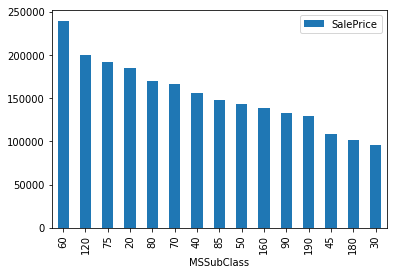

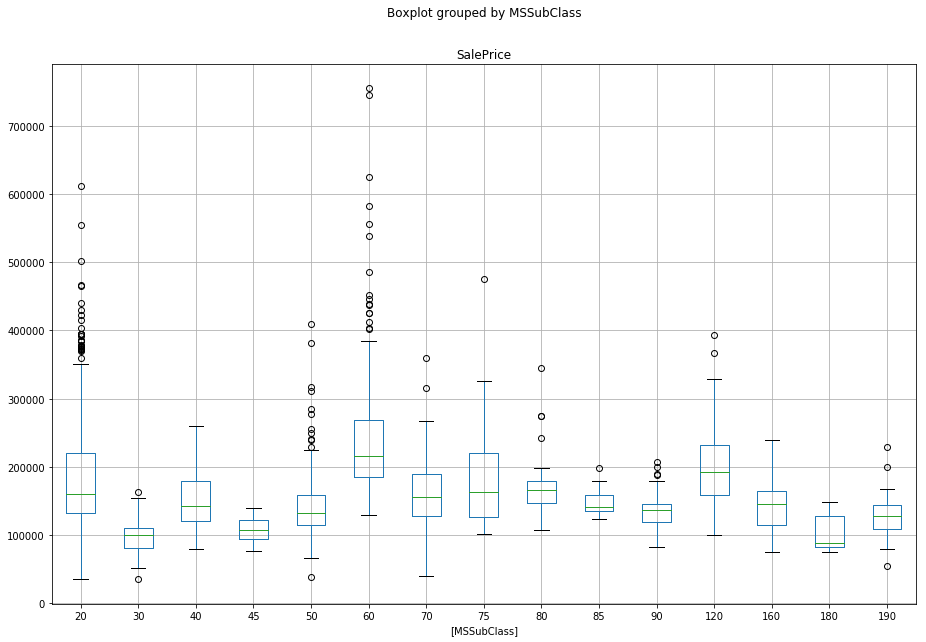

In [651]:
## Exploring MSSubClass

## MSSubClass versus SalePrice
mssubclass_grpby = h_train.groupby(['MSSubClass'])['SalePrice'].mean().reset_index()
mssubclass_grpby = mssubclass_grpby.sort_values('SalePrice', ascending = False)
mssubclass_grpby.index = mssubclass_grpby['MSSubClass']
mssubclass_grpby.drop(columns = ['MSSubClass']).plot.bar();

## MSSubClass versus SalePrice boxplot
mssubclass = h_train[['MSSubClass', 'SalePrice']]
mssubclass.boxplot(by = 'MSSubClass', figsize = (15,10));

#### Observations :

In order of average Sale Price, we can rank MSSubClasses according to Value:

1) 2-Story New Houses (299)

2) 1-Story New Houses (87)

3) 2.5-Story Houses (16)

4) 1-Story New Houses (536)

5) Split Houses (58)

6) 2-Story Old Houses (60)

In general, price appears to be most sensitive to, in order (a) Whether the house is old (b) How many stories the house has.

#### 2) Utilities:

 Do houses with more utilities sell for more?

In [652]:
h_train.groupby(['Utilities'])['SalePrice'].agg(['mean', 'count'])

,mean,count
Utilities,,
AllPub,180950.95682,1459
NoSeWa,137500.00000,1


We only have one house without all utilities, this does not give us a lot of information to work with. Might be a good idea to let this one go!

#### 3) Condition1 & Condition2:

These features provide information regarding proximity of the property with landmarks such as railway lines, parks, greenbelts, etc.

,mean,count
Condition1,,
Artery,135091.666667,48
Feedr,142475.481481,81
Norm,184495.492063,1260
PosA,225875.000000,8
PosN,215184.210526,19
RRAe,138400.000000,11
RRAn,184396.615385,26
RRNe,190750.000000,2
RRNn,212400.000000,5


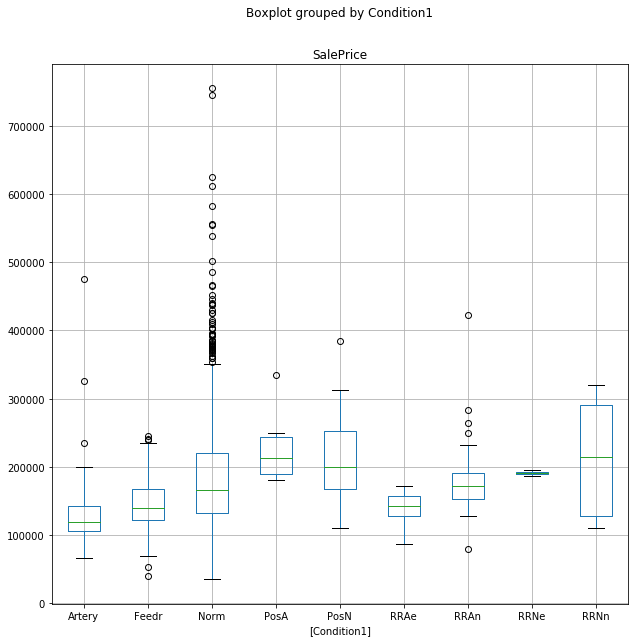

In [653]:
h_train[['Condition1', 'SalePrice']].boxplot(by = 'Condition1', figsize = (10,10));
h_train.groupby(['Condition1'])['SalePrice'].agg(['mean', 'count'])

Properties with conditions RRAn, PosA, PosN, and RRNe are associated with a higher sale price. It appears as though properties in close proximity with a Railway line, and a Positive site such as a park/greenbelt are more valuable. We can engineer binary features for proximity with a Railway line, and a Positive site.

#### 3) PlotArea : Our intuition states that higher LotAreas should be associated with higher SalePrices. Let's test.

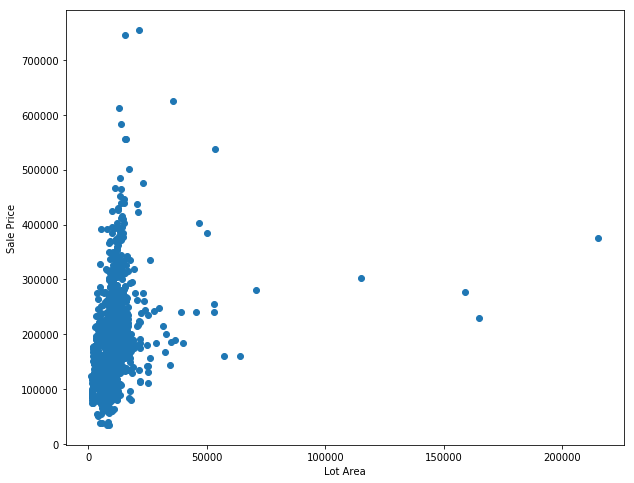

In [654]:
##Visualizing PlotArea versus SalePrice
plt.figure(figsize = (10,8))
plt.scatter(h_train.LotArea, h_train.SalePrice)
plt.xlabel('Lot Area')
plt.ylabel('Sale Price');

Quite a few outliers. Will need to deal with them to better understand nature of relationship between PlotArea and SalePrice.

In [655]:
## IQR of LotArea
lotarea_iqr = h_train.LotArea.describe()['75%'] - h_train.LotArea.describe()['25%']  ##IQR of LotArea
ub_la = h_train.LotArea.describe()['75%'] + 3*lotarea_iqr  ##Upper Bound

## IQR of SalePrice
saleprice_iqr = h_train.SalePrice.describe()['75%'] - h_train.SalePrice.describe()['25%']  ##IQR of LotArea
ub_sp = h_train.SalePrice.describe()['75%'] + 3*saleprice_iqr

## Dropping abnormally high LotArea AND SalePrice (these are potentially the 'snazzy' houses)
h_train = h_train[h_train['LotArea'] <= ub_la]
h_train = h_train[h_train['SalePrice'] <= ub_sp]

h_train.index = range(0, len(h_train))  ##Reordering index

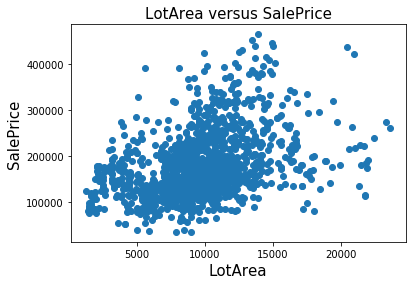

In [656]:
## Scatterplot of LotArea
plt.scatter(h_train.LotArea, h_train.SalePrice)
plt.xlabel('LotArea', size = 15)
plt.ylabel('SalePrice', size = 15)
plt.title('LotArea versus SalePrice', size = 15);

We see that a higher SalePrice is associated with a higher LotArea, as per our intuition. We need to engineer features before we can do any more EDA, since almost all other useful features are categorical.

### Feature Engineering

#### ZIPCODE: 25 neighborhoods are mentioned in the dataset. It would be better to convert them to ZIPCodes if we wish to capture the "locality" effects on price. I Googled the actual ZipCodes for these neighborhoods (Bloomington Heights, BlueStem, etc).

In [657]:
h_train.Neighborhood.values

neighs = h_train.Neighborhood.unique() ##All unique neighborhoods

ziplist = [50013, 50010, 50010, 50010, 50010, 50010, 50010, 50010, 50010, 50014, 50010, 50011, 50014, 50010, 50010,
          50014, 50014, 50010, 50010, 50010, 50010, 50010, 50010, 50011, 50014]
dictzip = {}
for i, j in zip(neighs, ziplist):
    dictzip[i] = j

h_train['ZIPCODE'] = [dictzip[i] for i in h_train['Neighborhood']] ## Replacing Neighborhood with ZIPs in h_train
h_test['ZIPCODE'] = [dictzip[i] for i in h_test['Neighborhood']] ## Replacing Neighborhood with ZIPs in h_train

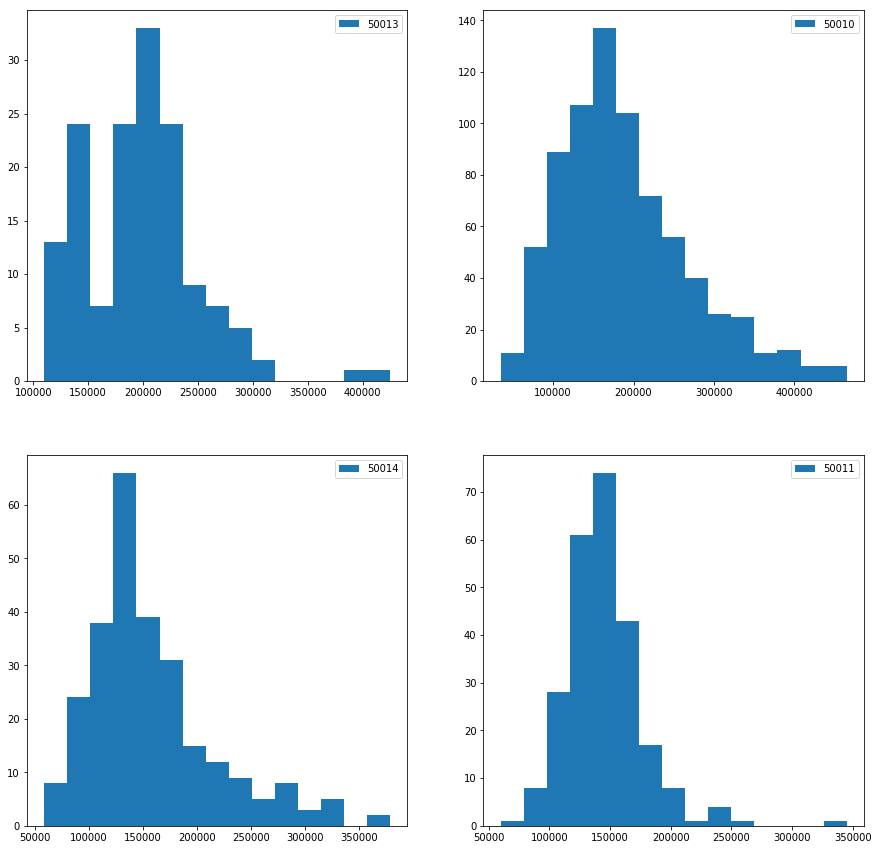

In [658]:
zips = h_train.ZIPCODE.unique()
zips
a = {}
for z in zips:
    a[z] = h_train[h_train.ZIPCODE == z]['SalePrice']

plt.figure(figsize = (15,15))
for z, i in zip(zips, range(1,5)):
    plt.subplot(2,2,i)
    plt.hist(a[z], bins = 15)
    plt.legend([z])

ZIPs 50013 and 50010 have a higher mean SalePrice, indicating they may be more expensive localities. Clearly, ZIPCODE is a vital feature, and we thus create one-hot encoded binary features for each ZIPcode.

In [659]:
nhood_vals = list(h_train.ZIPCODE.unique())
## Creating one-shot encoded variables against ZIPCODE for h_train and h_test
for i in nhood_vals:
    h_train['ZIP_{} = 1'.format(i)] = [1 if str(j) == str(i) else 0 for j in h_train['ZIPCODE']]

for i in nhood_vals:
    h_test['ZIP_{} = 1'.format(i)] = [1 if str(j) == str(i) else 0 for j in h_test['ZIPCODE']]


#### Stories: Extracting Number of Stories from HouseStyle

In [661]:
htypes = ['1Story','1.5Fin','1.5Unf','2Story','2.5Fin','2.5Unf','SFoyer','SLvl']
stories = [1, 2, 1.5, 2, 2.5, 2, 2, 2]
dictstors = {}
for i, j in zip(htypes, stories):
    dictstors[i] = j

h_train['Stories'] = [dictstors[i] for i in h_train['HouseStyle']]
h_test['Stories'] = [dictstors[i] for i in h_test['HouseStyle']]

#### LotVolume: LotArea * Stories

In [662]:
h_train['LotVolume'] = h_train['LotArea'] * h_train['Stories']
h_test['LotVolume'] = h_test['LotArea'] * h_test['Stories']

#### Total Porch Area

In [663]:
h_train['Total_Porch_Area'] = h_train['WoodDeckSF'] + h_train['OpenPorchSF'] + h_train['EnclosedPorch'] + h_train['3SsnPorch'] + h_train['ScreenPorch']
h_test['Total_Porch_Area'] = h_test['WoodDeckSF'] + h_test['OpenPorchSF'] + h_test['EnclosedPorch'] + h_test['3SsnPorch'] + h_test['ScreenPorch']

#### PosSiteProxim and RailwayProxim: 
Encoding for whether a property is close to a Railway line

In [664]:
conds = h_train['Condition1'].unique()
possite = conds[[2,7]] ## Codes for proximity to a Positive off-site
railprox = conds[[4,5,6,8]] ## Codes for proximity to a Railway line
condpos = conds[2:]

In [665]:
## Encoding for h_train
h_train['PosSiteProxim1'] = [1 if i in possite else 0 for i in h_train['Condition1']]
h_train['RailwayProxim1'] = [1 if i in railprox else 0 for i in h_train['Condition1']]
h_train['PosSiteProxim2'] = [1 if i in possite else 0 for i in h_train['Condition2']]
h_train['RailwayProxim2'] = [1 if i in railprox else 0 for i in h_train['Condition2']]
h_train['PosCond1'] = [1 if i in condpos else 0 for i in h_train['Condition1']]
h_train['PosCond2'] = [1 if i in condpos else 0 for i in h_train['Condition2']]


## Encoding for h_test
h_test['PosSiteProxim1'] = [1 if i in possite else 0 for i in h_test['Condition1']]
h_test['RailwayProxim1'] = [1 if i in railprox else 0 for i in h_test['Condition1']]
h_test['PosSiteProxim2'] = [1 if i in possite else 0 for i in h_test['Condition2']]
h_test['RailwayProxim2'] = [1 if i in railprox else 0 for i in h_test['Condition2']]
h_test['PosCond1'] = [1 if i in condpos else 0 for i in h_test['Condition1']]
h_test['PosCond2'] = [1 if i in condpos else 0 for i in h_test['Condition2']]

count    median            std
PosCond1 PosCond2                                
0        0          1298  162700.0   70546.467909
         1             4  130952.5   49849.399925
1        0           110  153737.5   61612.884920
         1             4  221500.0  145850.094275

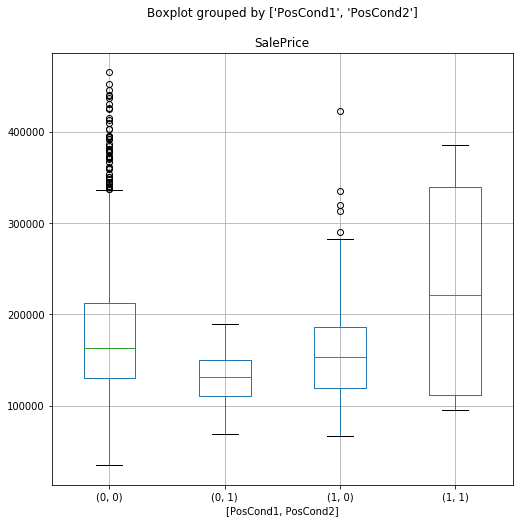

In [666]:
h_train_conds = h_train[['PosCond1', 'PosCond2', 'SalePrice']]
h_train_conds.boxplot(by = ['PosCond1', 'PosCond2'], figsize = (8,8))
h_train.groupby(['PosCond1', 'PosCond2'])['SalePrice'].agg(['count','median', 'std'])


The difference in SalePrice in the presence of a PositiveCondition does not appear to be statstically significant, however this may be confounded by other factors such as property area, and ZIPcode, etc.

#### HouseAge_AtSale*: 

#### Checks the difference between sale year and purchase/build year, and difference between sale year and remodelled year - takes the minimum value of the two.

In [667]:
house_age_at_sale1 = []
for i in range(len(h_train['YrSold'])):
    try:
        house_age_at_sale1.append(min(h_train['YrSold'][i] - h_train['YearBuilt'][i], 
                                    h_train['YrSold'][i] - h_train['YearRemodAdd'][i]))
    except Exception as e:
        print(Exception)
        continue

h_train['HouseAge_AtSale'] = pd.Series(house_age_at_sale1)

house_age_at_sale2 = []
for i in range(len(h_test['YrSold'])):
    try:
        house_age_at_sale2.append(min(h_test['YrSold'][i] - h_test['YearBuilt'][i], 
                                    h_test['YrSold'][i] - h_test['YearRemodAdd'][i]))
    except:
        continue


h_test['HouseAge_AtSale'] = pd.Series(house_age_at_sale2)

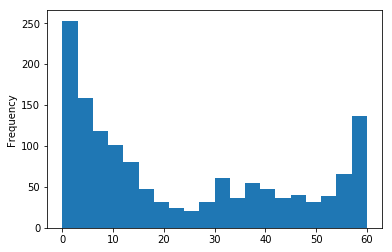

In [668]:
h_train.HouseAge_AtSale.plot.hist(bins = 20);

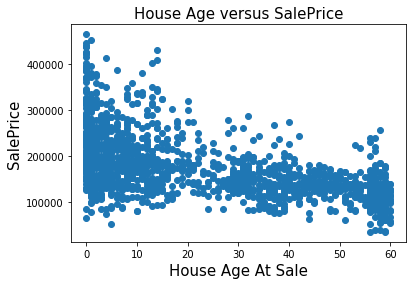

In [669]:
plt.scatter(h_train.HouseAge_AtSale, h_train.SalePrice)
plt.xlabel('House Age At Sale', size = 15)
plt.ylabel('SalePrice', size = 15)
plt.title('House Age versus SalePrice', size = 15);

HouseAge_AtSale appears to be negatively correlated with the SalePrice.

#### Rating: 

OverallQual and OverallCond are features that provide information about human-ratings for the property. We take the sum of these features to create the Rating feature.

In [670]:
h_train['Rating'] = h_train.OverallQual + h_train.OverallCond
h_test['Rating'] = h_test.OverallQual + h_test.OverallCond

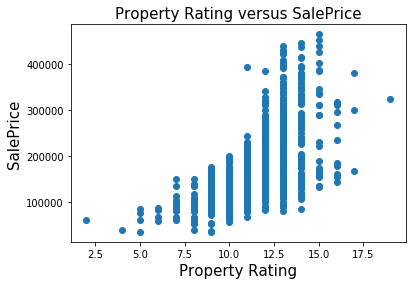

In [671]:
plt.scatter(h_train.Rating, h_train.SalePrice)
plt.xlabel('Property Rating', size = 15)
plt.ylabel('SalePrice', size = 15)
plt.title('Property Rating versus SalePrice', size = 15);

As we would expect, there is a positive correlation between property ratings and SalePrice, although there appears to be a "fanning out" for properties with higher ratings. This can be corrected by log transforming the variable to obtain maximum predictive power.

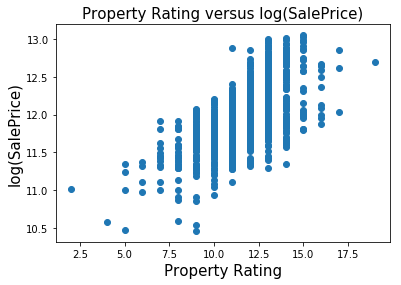

In [672]:
plt.scatter(h_train.Rating, np.log(h_train.SalePrice))
plt.xlabel('Property Rating', size = 15)
plt.ylabel('log(SalePrice)', size = 15)
plt.title('Property Rating versus log(SalePrice)', size = 15);

Looks much more linear now!

#### LotFrontage:

This is the available extraneous area to the property, this could be a useful feature.

Missing Values for LotFrontage : 243


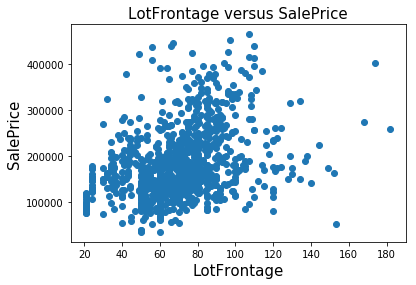

In [673]:
plt.scatter(h_train.LotFrontage, h_train.SalePrice)
plt.xlabel('LotFrontage', size = 15)
plt.ylabel('SalePrice', size = 15)
plt.title('LotFrontage versus SalePrice', size = 15);
print('Missing Values for LotFrontage : {0}'.format(h_train.LotFrontage.isnull().sum()))

LotFrontage has many missing values though, we need to impute them. There is a correlation with LotArea (larger homes tend to have larger frontage area). We can thus regress LotFrontage on LotArea to get values for LotFrontage.

In [674]:
from sklearn import linear_model
y = h_train[h_train.LotFrontage.isnull() == False].LotFrontage
x = h_train[h_train.LotFrontage.isnull() == False].LotVolume

lotfront = linear_model.LinearRegression()
x = np.array(x)
y = np.array(y)
x = x.reshape(len(x), 1)
y = y.reshape(len(x), 1)

lotfrontfit = lotfront.fit(x,y)

##Replace NaNs with 0s
h_train.LotFrontage = h_train.LotFrontage.fillna(0)
h_test.LotFrontage = h_test.LotFrontage.fillna(0)

#### LFClean

In [675]:
h_train['LFClean'] = [h_train.LotFrontage[i] if h_train.LotFrontage[i] != 0 
                  else int(lotfrontfit.predict(h_train.LotVolume[i])) for i in range(len(h_train.LotFrontage))]

h_test['LFClean'] = [h_test.LotFrontage[i] if h_test.LotFrontage[i] != 0 
                  else int(lotfrontfit.predict(h_test.LotVolume[i])) for i in range(len(h_test.LotFrontage))]

#### ExterRating

Combines data from External Quality rating and External Conditional rating (categorical variables).

In [676]:
## Assigning a 1-5 scale to qualities and conditions.
qualcodes = ['Ex', 'Gd', 'TA', 'Fa', 'Po']

qualdict = {}

for q,r in zip(qualcodes, range(5,0, -1)):
    qualdict[q] = r

h_train['E1'] = [qualdict[i] for i in h_train['ExterQual']]
h_train['E2'] = [qualdict[i] for i in h_train['ExterCond']]
h_train['ExterRating'] = h_train['E1'] + h_train['E2']

h_test['E1'] = [qualdict[i] for i in h_test['ExterQual']]
h_test['E2'] = [qualdict[i] for i in h_test['ExterCond']]
h_test['ExterRating'] = h_test['E1'] + h_test['E2']

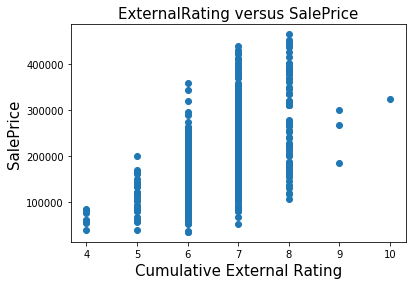

In [677]:
plt.scatter(h_train.ExterRating, h_train.SalePrice)
plt.xlabel('Cumulative External Rating', size = 15)
plt.ylabel('SalePrice', size = 15)
plt.title('ExternalRating versus SalePrice', size = 15);

#### We now extract all features we engineered, and existing numerical features to start modeling.

In [678]:
dat_train = h_train[['LFClean', 'LotArea', 'Stories','LotVolume', 'ZIP_50010 = 1', 'ZIP_50011 = 1', 'ZIP_50013 = 1', 'ZIP_50014 = 1',
                    'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea', 'BedroomAbvGr','KitchenAbvGr',
                    'TotRmsAbvGrd', 'GarageArea', 'Total_Porch_Area', 'PosSiteProxim1', 'RailwayProxim1',
                     'PosSiteProxim2', 'RailwayProxim2','HouseAge_AtSale', 'Rating', 'ExterRating', 'SalePrice']]

With feature engineering and manual selection, we reduce the number of features to 26. We need to look for statistical significance and prediction power for each of these variables, we do so during modeling.

In [679]:
dat_train.shape

(1416, 26)

### LINEAR MODELS

#### Ridge Regression:
Ridge regression is a powerful shrinkage method, particularly efficient when we have multiple correlated variables. The Ridge adds a penalty to "heavier" coefficients with the L2 norm proportional to the hyperparameter $\lambda$ determined by the modeler, effectively restricting the possible search space for the parameters to a circle (if your model has two predictor features), or more generally a hypersphere in higher dimensions.


#### Lasso Regression:
Lasso is similar in principle to Ridge, except the parameter search-space constraint we impose on the minimization function is now the L1 norm. The locus of all possible parameters would thus be this rhombus shaped object in 2-D, or a polyhedron in higher dimensions. Since polyhedra have "sharp" corners, the probability of the Likelihood function touching these corners is high - this basically means Lasso automatically performs variable selection as well.


#### ElasticNet:
Invented by the legendary Hastie not very long ago, ElasticNet aims to find the sweet-spot between the coefficient shrinkage offered by Ridge and the variable selection of Lasso by introducing another hyperparameter $\alpha$ that regularizes the $\lambda$.


All of these are regularization methods that aim to imcrease the generalizability of our models to wild, unseen data (by reducing overfitting to the noise in the training data). These methods increases the bias in the model, with the hope of bringing down model variance. For more information on regularization methods in general:

https://en.wikipedia.org/wiki/Regularization_(mathematics)_


In [680]:
from sklearn.preprocessing import StandardScaler ## For pre-processing features
from sklearn.model_selection import train_test_split ##For building testing and validation sets
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold ## Cross-Validation

In [681]:
## Separating Features and Target variables
x_data = dat_train[dat_train.columns[0:-1]]
y_data = dat_train[dat_train.columns[-1]]

##Splitting into train, test data
x_data_train, x_data_test, y_data_train, y_data_test = train_test_split(x_data, y_data, test_size = 0.3, random_state = 42)

The evaluation metric is the Root Mean Squared Log Error, or RMSLE. 

In [682]:
## RMSLE Error Cost Function
def rmsle(y_pred, y_act):
    y_pred_log = np.log(y_pred + 1)
    y_act_log = np.log(y_act + 1)
    return np.sqrt(sum((y_pred_log - y_act_log)**2)/len(y_act_log))

Ridge

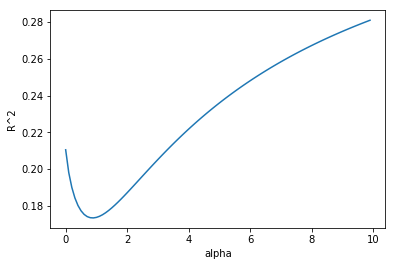

In [683]:
## Ridge_Test

alphas = np.arange(0,10,0.1)
params = []
rscores = []
for a in alphas:
    ridge_fit = Ridge(alpha = a, normalize = True).fit(x_data_train, y_data_train)
    y_pred = ridge_fit.predict(x_data_test)
    rscores.append(rmsle(y_pred, y_data_test))
    
plt.plot(alphas, rscores)
plt.xlabel('alpha')
plt.ylabel('R^2');

The optimal value of the tuning parameter is ~ 0.2, let us use K-Fold cross validation to find the best value. We set K = 5.

In [684]:
## To find RMSLE OF test sets
def RidgeCVScorer(X_CV_train, X_CV_test, Y_CV_train, Y_CV_test, al):
    ridgfit = Ridge(alpha = al, normalize = True).fit(X_CV_train, Y_CV_train)
    rMSLE = rmsle(ridgfit.predict(X_CV_test), Y_CV_test)
    return rMSLE


In [685]:
## Using 5-fold CV to tune the regularization parameter

kf = KFold(n_splits = 7, random_state = 42, shuffle = True)
alphas = np.arange(0.1,10,0.1)
ridgealpha_scores = {}
for al in alphas:
    rscores = []
    for train_index, test_index in kf.split(x_data_train):
        X_CV_train, X_CV_test, Y_CV_train, Y_CV_test = x_data.loc[train_index], x_data.loc[test_index], y_data.loc[train_index], y_data.loc[test_index]   
        rscores.append(RidgeCVScorer(X_CV_train, X_CV_test, Y_CV_train, Y_CV_test, al))
    ridgealpha_scores[al] = rscores

C:\Users\Vishnu\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


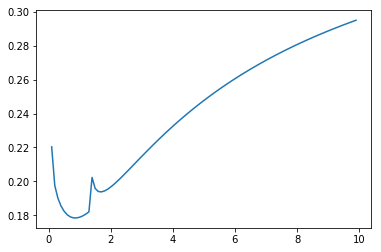

In [687]:
RIDGE_eval = pd.DataFrame.from_dict(ridgealpha_scores)
RIDGE_eval.mean().plot();

From 5-fold CV, we see that the best value of alpha is 0.7.

LASSO

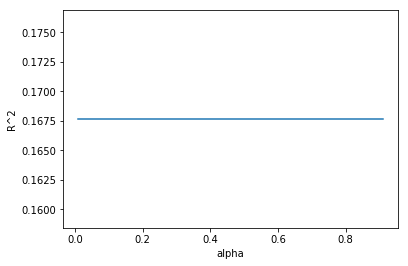

In [689]:
## To find R^2 of test sets

def LassoCVScorer(X_CV_train, X_CV_test, Y_CV_train, Y_CV_test, al):
    lassfit = Lasso(alpha = al, normalize = True).fit(X_CV_train, Y_CV_train)
    r2 = rmsle(lassfit.predict(X_CV_test), Y_CV_test)
    return r2

alphas = np.arange(0.01,1,0.1)
params = []
lscores = []
for a in alphas:
    lasso_fit = Lasso(alpha = a, normalize = True, max_iter = 10000).fit(x_data_train, y_data_train)
    lasso_fit.predict(x_data_test)
    lscores.append(LassoCVScorer(X_CV_train, X_CV_test, Y_CV_train, Y_CV_test, al))
    
plt.plot(alphas, lscores)
plt.xlabel('alpha')
plt.ylabel('R^2');

In [690]:
## Using 5-fold CV to tune the regularization parameter

kf = KFold(n_splits = 5, random_state = 42, shuffle = True)
alphas = np.arange(5,1000,10)
lassoalpha_scores = {}
for al in alphas:
    lscores = []
    for train_index, test_index in kf.split(x_data_train):
        X_CV_train, X_CV_test, Y_CV_train, Y_CV_test = x_data.loc[train_index], x_data.loc[test_index], y_data.loc[train_index], y_data.loc[test_index]   
        lscores.append(LassoCVScorer(X_CV_train, X_CV_test, Y_CV_train, Y_CV_test, al))
    lassoalpha_scores[al] = lscores

C:\Users\Vishnu\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


RMSLE on test data for LASSO model is: 0.17


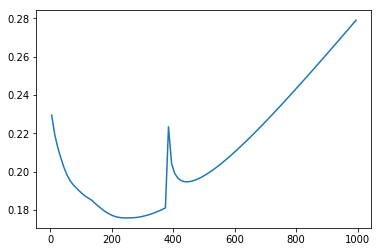

In [691]:
LASSO_eval = pd.DataFrame.from_dict(lassoalpha_scores)
LASSO_eval.mean().plot();

lfit = Lasso(alpha =  200, normalize = True).fit(x_data_train, y_data_train)
print('RMSLE on test data for LASSO model is: {0}'.format(round(rmsle(lfit.predict(x_data_test), y_data_test),2)))

#### RMSLE values and Regularization parameters for Ridge and LASSO regression:

In [692]:
lfit = Lasso(alpha = 200, normalize = True).fit(x_data_train, y_data_train)
y_pred_l = lfit.predict(x_data_test)
print('Best LASSO RMSLE: ',round(rmsle(y_pred_l, y_data_test),3), '~','Alpha :', 200)

rfit = Ridge(alpha = 0.7, normalize = True).fit(x_data_train, y_data_train)
y_pred_r = rfit.predict(x_data_test)
print('Best Ridge RMSLE', round(rmsle(y_pred_r, y_data_test),3), '~','Alpha :', 0.7)


Best LASSO RMSLE:  0.169 ~ Alpha : 200
Best Ridge RMSLE 0.174 ~ Alpha : 0.7


ElasticNet